## Step 1: Load Data & Generate Spectra

Loading data...
Successfully loaded Detector A: 40000 events found.
Successfully loaded Detector B: 40000 events found.
Successfully loaded Detector C: 40000 events found.
Successfully loaded Detector Target: 4902 events found.


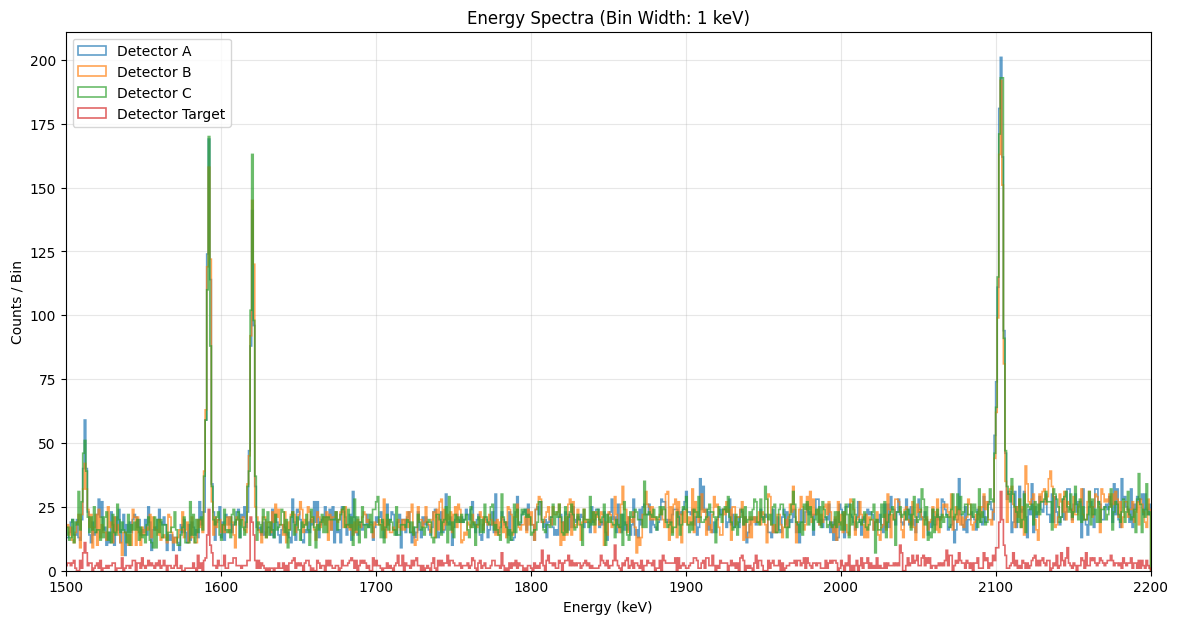

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_and_plot_spectra():
    # Configuration: 1500-2200 keV range, 1 keV bins
    MIN_ENERGY = 1500
    MAX_ENERGY = 2200
    BIN_WIDTH = 1

    bins = np.arange(MIN_ENERGY, MAX_ENERGY + BIN_WIDTH, BIN_WIDTH)

    file_list = {
        'Detector A': 'DetectorA.csv',
        'Detector B': 'DetectorB.csv',
        'Detector C': 'DetectorC.csv',
        'Detector Target': 'DetectorTarget.csv'
    }

    data_frames = {}

    print("Loading data...")
    column_names = ['Event ID', 'Classification Score', 'Energy']

    for label, filename in file_list.items():
        try:
            df = pd.read_csv(filename, header=None, names=column_names)
            data_frames[label] = df
            print(f"Successfully loaded {label}: {len(df)} events found.")
        except FileNotFoundError:
            print(f"Error: {filename} not found.")
            return None, None

    # Plot raw energy spectra for inspection
    plt.figure(figsize=(14, 7))

    for label, df in data_frames.items():
        plt.hist(df['Energy'], bins=bins, histtype='step', linewidth=1.2, label=label, alpha = 0.7)

    plt.title(f"Energy Spectra (Bin Width: {BIN_WIDTH} keV)")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts / Bin")
    plt.xlim(MIN_ENERGY, MAX_ENERGY)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.show()

    return data_frames, bins

loaded_data, energy_bins = load_and_plot_spectra()

## Step 2: Using Detector A's 1592 keV peak to calculate the True Positive Rate (TPR) curve while performing baseline subtraction

Signal Window: 1587-1597 keV
Background Window: 1550-1570 keV
Baseline Scale Factor: 0.5


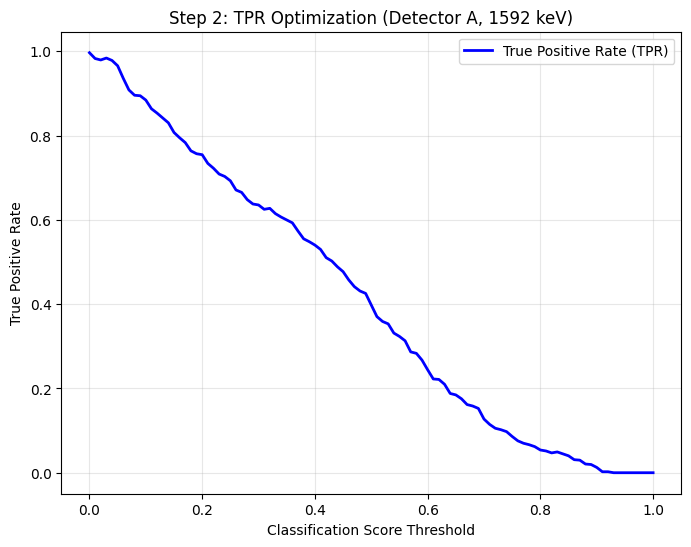


--- TPR Lookup Table ---
Threshold  | TPR       
-------------------------
0.00       | 0.9966
0.05       | 0.9656
0.10       | 0.8842
0.15       | 0.8073
0.20       | 0.7546
0.25       | 0.6927
0.30       | 0.6353
0.35       | 0.5998
0.40       | 0.5401
0.45       | 0.4771
0.50       | 0.3979
0.55       | 0.3234
0.60       | 0.2443
0.65       | 0.1846
0.70       | 0.1273
0.75       | 0.0860
0.80       | 0.0539
0.85       | 0.0401
0.90       | 0.0126
0.95       | 0.0000
1.00       | 0.0000


In [4]:
def calculate_and_plot_tpr(df_detector_A):
    # Signal Region: 1592 keV peak (+/- 5 keV)
    SIG_CENTER = 1592
    SIG_HALF_WIDTH = 5
    sig_min = SIG_CENTER - SIG_HALF_WIDTH
    sig_max = SIG_CENTER + SIG_HALF_WIDTH

    # Background Sideband: Flat region to the left (1550-1570 keV)
    bkg_min = 1550
    bkg_max = 1570

    # Scaling factor for baseline subtraction based on window widths
    sig_width = sig_max - sig_min
    bkg_width = bkg_max - bkg_min
    scale_factor = sig_width / bkg_width

    print(f"Signal Window: {sig_min}-{sig_max} keV")
    print(f"Background Window: {bkg_min}-{bkg_max} keV")
    print(f"Baseline Scale Factor: {scale_factor}")

    # Sweep thresholds from 0.0 to 1.0
    thresholds = np.linspace(0, 1, 101)
    tpr_values = []

    # Pre-filter events by energy window
    events_in_sig = df_detector_A[(df_detector_A['Energy'] >= sig_min) & (df_detector_A['Energy'] < sig_max)]
    events_in_bkg = df_detector_A[(df_detector_A['Energy'] >= bkg_min) & (df_detector_A['Energy'] < bkg_max)]

    # Calculate Total True Signal (Denominator) using baseline subtraction
    total_raw_sig = len(events_in_sig)
    total_raw_bkg = len(events_in_bkg)
    total_true_signal = total_raw_sig - (total_raw_bkg * scale_factor)

    if total_true_signal <= 0:
        print("Warning: Background subtraction resulted in <= 0 signal.")
        return

    for t in thresholds:
        # Apply classification score cut
        cut_sig = events_in_sig[events_in_sig['Classification Score'] > t]
        cut_bkg = events_in_bkg[events_in_bkg['Classification Score'] > t]

        n_sig = len(cut_sig)
        n_bkg = len(cut_bkg)

        # Subtract baseline from surviving signal events
        n_true_signal_remaining = n_sig - (n_bkg * scale_factor)

        # TPR = (Signal Remaining) / (Total Signal)
        tpr = n_true_signal_remaining / total_true_signal
        tpr_values.append(tpr)

    # Plot TPR Curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, tpr_values, label='True Positive Rate (TPR)', color='blue', linewidth=2)
    plt.title("Step 2: TPR Optimization (Detector A, 1592 keV)")
    plt.xlabel("Classification Score Threshold")
    plt.ylabel("True Positive Rate")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print("\n--- TPR Lookup Table ---")
    print(f"{'Threshold':<10} | {'TPR':<10}")
    print("-" * 25)
    for t, tpr in zip(thresholds[::5], tpr_values[::5]):
        print(f"{t:.2f}       | {tpr:.4f}")

    return thresholds, tpr_values

if 'loaded_data' in locals():
    thresh, tprs = calculate_and_plot_tpr(loaded_data['Detector A'])
else:
    print("Please run Step 1 code first.")

## Step 3: Calculating False Positive Rate (FPR) using Detector B

Background Peak Window: 2098-2108 keV
Sideband Window: 2120-2140 keV
Baseline Scale Factor: 0.5000


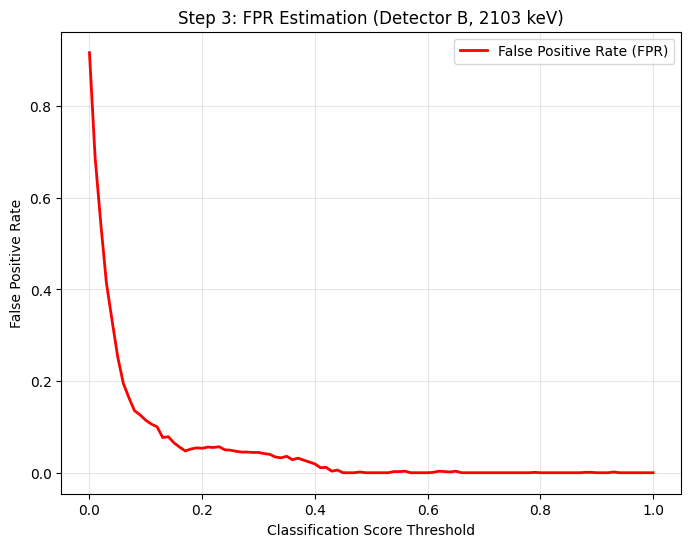


--- FPR Lookup Table ---
Threshold  | FPR       
-------------------------
0.00       | 0.9165
0.05       | 0.2538
0.10       | 0.1144
0.15       | 0.0651
0.20       | 0.0534
0.25       | 0.0492
0.30       | 0.0442
0.35       | 0.0359
0.40       | 0.0192
0.45       | 0.0000
0.50       | 0.0000
0.55       | 0.0025
0.60       | 0.0000
0.65       | 0.0033
0.70       | 0.0000
0.75       | 0.0000
0.80       | 0.0000
0.85       | 0.0000
0.90       | 0.0000
0.95       | 0.0000
1.00       | 0.0000


In [5]:
def calculate_and_plot_fpr(df_detector_B):
    # Background Target: 2103 keV peak (+/- 5 keV)
    BKG_PEAK_CENTER = 2103
    HALF_WIDTH = 5
    win_min = BKG_PEAK_CENTER - HALF_WIDTH
    win_max = BKG_PEAK_CENTER + HALF_WIDTH

    # Sideband: Clean, flat region (2120-2140 keV)
    sb_min = 2120
    sb_max = 2140

    # Scaling factor for baseline subtraction
    win_width = win_max - win_min
    sb_width = sb_max - sb_min
    scale_factor = win_width / sb_width

    print(f"Background Peak Window: {win_min}-{win_max} keV")
    print(f"Sideband Window: {sb_min}-{sb_max} keV")
    print(f"Baseline Scale Factor: {scale_factor:.4f}")

    thresholds = np.linspace(0, 1, 101)
    fpr_values = []

    # Pre-filter events
    events_in_peak = df_detector_B[(df_detector_B['Energy'] >= win_min) & (df_detector_B['Energy'] < win_max)]
    events_in_sb = df_detector_B[(df_detector_B['Energy'] >= sb_min) & (df_detector_B['Energy'] < sb_max)]

    # Calculate Total True Background (Denominator)
    total_raw_peak = len(events_in_peak)
    total_raw_sb = len(events_in_sb)
    total_true_bkg_events = total_raw_peak - (total_raw_sb * scale_factor)

    if total_true_bkg_events <= 0:
        print("Warning: Subtraction resulted in <= 0 events.")
        return

    for t in thresholds:
        # Count background events passing the cut
        cut_peak = events_in_peak[events_in_peak['Classification Score'] > t]
        cut_sb = events_in_sb[events_in_sb['Classification Score'] > t]

        n_peak = len(cut_peak)
        n_sb = len(cut_sb)

        # Subtract baseline from numerator
        n_bkg_remaining = n_peak - (n_sb * scale_factor)

        # FPR = (Remaining Background) / (Total Background)
        # Max(0) prevents negative noise fluctuations
        fpr = max(0, n_bkg_remaining / total_true_bkg_events)
        fpr_values.append(fpr)

    # Plot FPR Curve
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, fpr_values, label='False Positive Rate (FPR)', color='red', linewidth=2)
    plt.title("Step 3: FPR Estimation (Detector B, 2103 keV)")
    plt.xlabel("Classification Score Threshold")
    plt.ylabel("False Positive Rate")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print("\n--- FPR Lookup Table ---")
    print(f"{'Threshold':<10} | {'FPR':<10}")
    print("-" * 25)
    for t, fpr in zip(thresholds[::5], fpr_values[::5]):
        print(f"{t:.2f}       | {fpr:.4f}")

    return thresholds, fpr_values

if 'loaded_data' in locals():
    thresh_fpr, fprs = calculate_and_plot_fpr(loaded_data['Detector B'])
else:
    print("Please ensure 'loaded_data' is available from Step 1.")

- Looking at the plots generated from Step 2 and Step 3, we decide to use a cut threshold of 0.15 for optimal results.

## Step 4: Generate the NLDBD PDF

Generating NLDBD PDF: Gaussian(mu=2039.0, sigma=1.0)


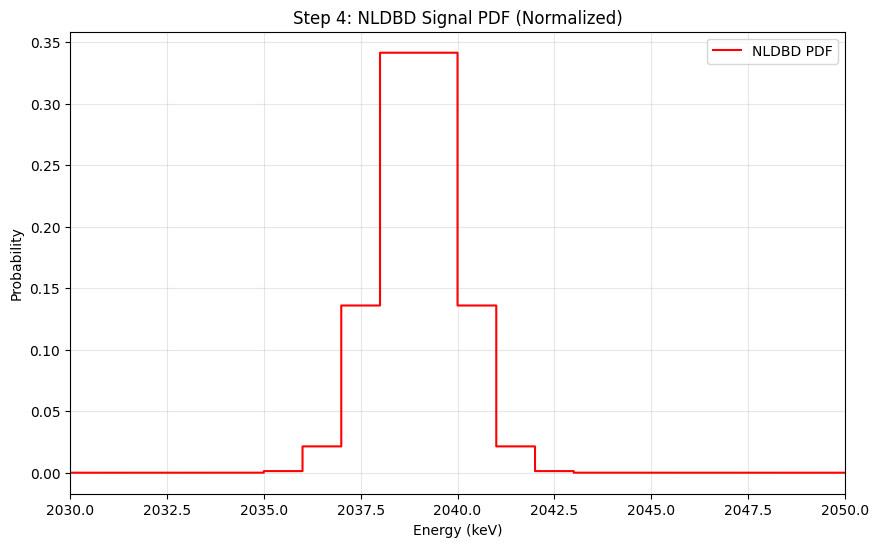

In [6]:
import scipy.stats as stats

def generate_nldbd_pdf(bins):
    # Gaussian Parameters: Center 2039 keV, Width 1 keV
    mu = 2039.0
    sigma = 1.0

    print(f"Generating NLDBD PDF: Gaussian(mu={mu}, sigma={sigma})")

    # Discretize Gaussian via CDF integration per bin
    upper_edges = bins[1:]
    lower_edges = bins[:-1]

    prob_in_bins = stats.norm.cdf(upper_edges, loc=mu, scale=sigma) - \
                   stats.norm.cdf(lower_edges, loc=mu, scale=sigma)

    # Normalize to ensure sum equals 1
    total_prob = np.sum(prob_in_bins)
    nldbd_pdf = prob_in_bins / total_prob

    # Plot PDF
    plt.figure(figsize=(10, 6))
    bin_centers = (upper_edges + lower_edges) / 2

    plt.plot(bin_centers, nldbd_pdf, drawstyle='steps-mid', color='red', label='NLDBD PDF')

    plt.xlim(2030, 2050)
    plt.title("Step 4: NLDBD Signal PDF (Normalized)")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return nldbd_pdf

if 'energy_bins' in locals():
    nldbd_pdf = generate_nldbd_pdf(energy_bins)
else:
    print("Please run Step 1 to define 'energy_bins' first.")

## Step 5: Applying the cut and generating the final PDFs (Probability Density Functions) for the fitting process

Applying Cut Threshold: 0.15


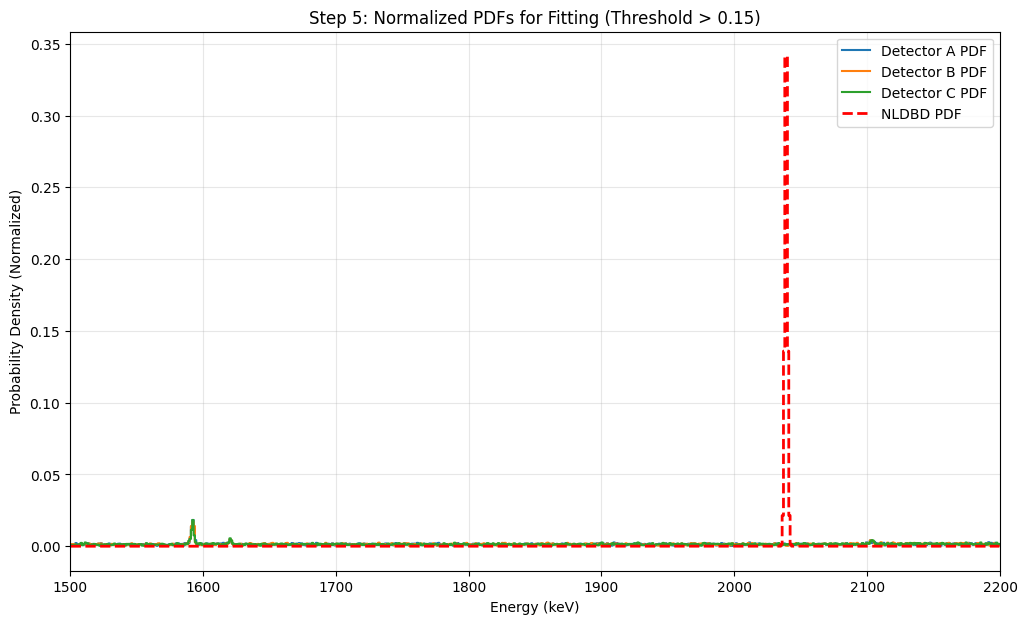

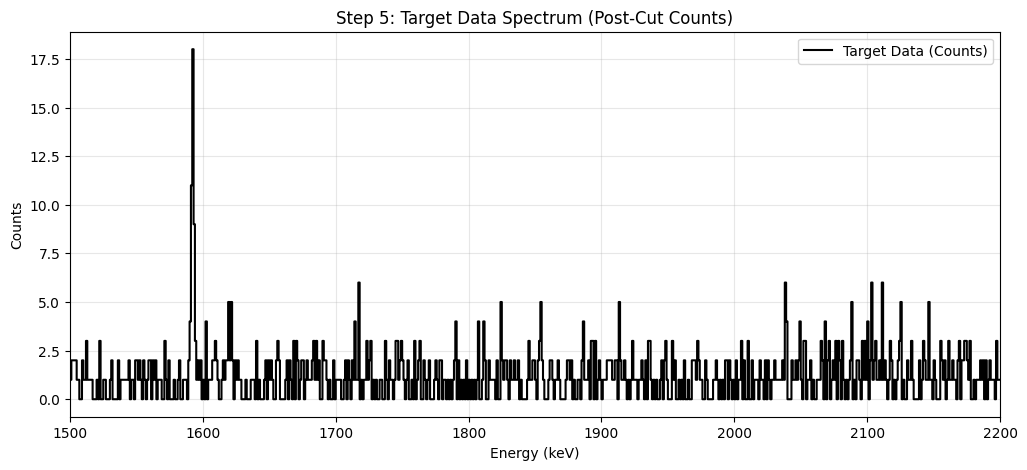

Step 5 Complete: PDFs generated and Target counts extracted.


In [7]:
def generate_fitting_pdfs(data_frames, bins, nldbd_pdf, cut_threshold=0.15):
    print(f"Applying Cut Threshold: {cut_threshold}")

    # Initialize container for fitting inputs
    fitting_inputs = {
        'PDFs': {},
        'Target_Counts': None,
        'Bin_Centers': (bins[1:] + bins[:-1]) / 2,
        'Bin_Edges': bins
    }

    fitting_inputs['PDFs']['NLDBD'] = nldbd_pdf

    # 1. Process Detectors A, B, C (Normalized PDFs)
    plt.figure(figsize=(12, 7))

    for label in ['Detector A', 'Detector B', 'Detector C']:
        df = data_frames[label]

        # Apply score cut
        cut_data = df[df['Classification Score'] > cut_threshold]['Energy']

        # Histogram and Normalize
        counts, _ = np.histogram(cut_data, bins=bins)

        total_counts = np.sum(counts)
        if total_counts > 0:
            pdf = counts / total_counts
        else:
            pdf = np.zeros_like(counts, dtype=float)
            print(f"Warning: {label} has 0 events after cut!")

        fitting_inputs['PDFs'][label] = pdf

        plt.plot(fitting_inputs['Bin_Centers'], pdf, drawstyle='steps-mid', label=f"{label} PDF", linewidth=1.5)

    # Overlay NLDBD PDF
    plt.plot(fitting_inputs['Bin_Centers'], nldbd_pdf, drawstyle='steps-mid',
             label='NLDBD PDF', color='red', linestyle='--', linewidth=2)

    plt.title(f"Step 5: Normalized PDFs for Fitting (Threshold > {cut_threshold})")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Probability Density (Normalized)")
    plt.xlim(1500, 2200)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # 2. Process Target (Raw Counts - No Normalization)
    df_target = data_frames['Detector Target']
    cut_target = df_target[df_target['Classification Score'] > cut_threshold]['Energy']
    target_counts, _ = np.histogram(cut_target, bins=bins)

    fitting_inputs['Target_Counts'] = target_counts

    # Visualize Target Spectrum
    plt.figure(figsize=(12, 5))
    plt.plot(fitting_inputs['Bin_Centers'], target_counts, drawstyle='steps-mid', color='black', label='Target Data (Counts)')
    plt.title(f"Step 5: Target Data Spectrum (Post-Cut Counts)")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Counts")
    plt.xlim(1500, 2200)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print("Step 5 Complete: PDFs generated and Target counts extracted.")
    return fitting_inputs

if 'loaded_data' in locals() and 'nldbd_pdf' in locals():
    fitting_data = generate_fitting_pdfs(loaded_data, energy_bins, nldbd_pdf, cut_threshold=0.15)
else:
    print("Please run Steps 1 and 4 first.")

## Step 6: The Frequentist Fit

--- Calculating Efficiencies (Cut > 0.15) ---
Detector A: 0.3834 (15334/40000 events kept)
Detector B: 0.3869 (15476/40000 events kept)
Detector C: 0.3881 (15524/40000 events kept)
Detector Target: 0.3841 (1883/4902 events kept)

Starting Corrected Fit...

Fit Successful!
Theta A (Total):     1190.41 (Expected ~1350)
Theta B (Total):     752.80 (Expected ~770)
Theta C (Total):     116.55
Theta NLDBD (Total): 8.03


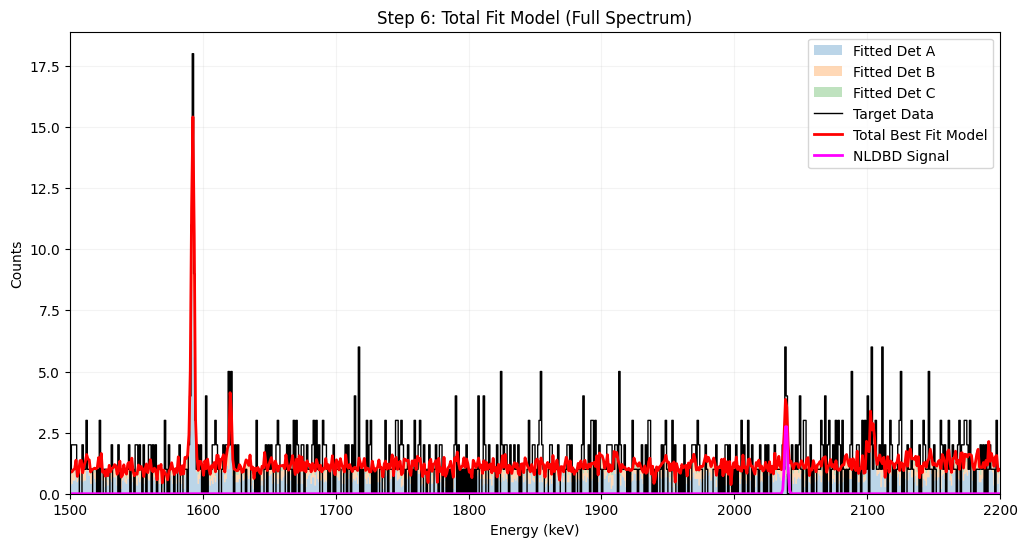

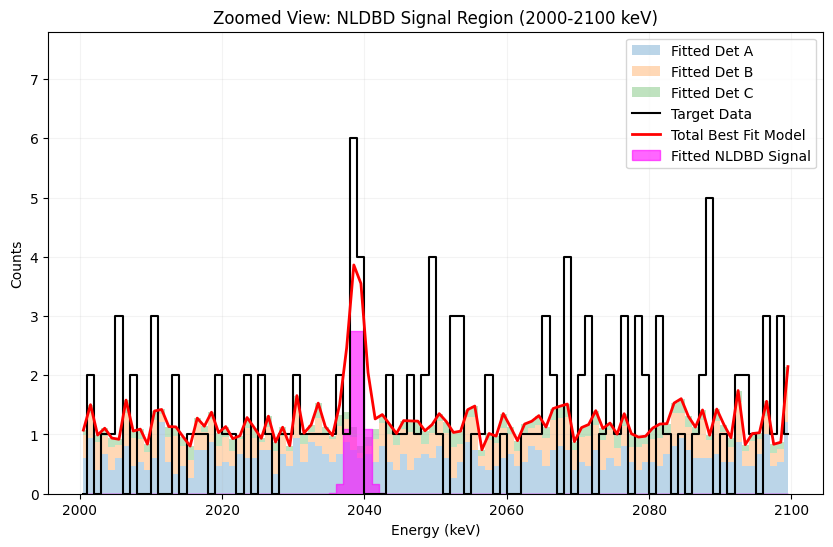

In [8]:
import scipy.optimize as optimize

# Calculate Cut Efficiencies for Efficiency Correction
def calculate_efficiencies(data_frames, cut_threshold):
    efficiencies = {}
    print(f"--- Calculating Efficiencies (Cut > {cut_threshold}) ---")

    for label, df in data_frames.items():
        total_events = len(df)
        kept_events = len(df[df['Classification Score'] > cut_threshold])

        if total_events > 0:
            eff = kept_events / total_events
        else:
            eff = 0.0

        efficiencies[label] = eff
        print(f"{label}: {eff:.4f} ({kept_events}/{total_events} events kept)")

    # Assume Signal efficiency matches Detector A (Calibration Source)
    efficiencies['NLDBD'] = efficiencies['Detector A']

    return efficiencies

# NLL Loss Function with Gaussian Penalty Terms
def nll_loss_corrected(params, pdfs, target_counts, constraints, efficiencies):
    theta_A, theta_B, theta_C, theta_NLDBD = params

    # Model = Total Count * Efficiency * PDF_Shape
    model_counts = (theta_A * efficiencies['Detector A'] * pdfs['Detector A'] +
                    theta_B * efficiencies['Detector B'] * pdfs['Detector B'] +
                    theta_C * pdfs['Detector C'] +
                    theta_NLDBD * pdfs['NLDBD'])

    # Add epsilon to avoid log(0)
    epsilon = 1e-10
    model_counts = np.maximum(model_counts, epsilon)

    # Poisson NLL
    poisson_nll = np.sum(model_counts - target_counts * np.log(model_counts))

    # Gaussian Constraints for Calibration parameters
    mu_A, sigma_A = constraints['A']
    mu_B, sigma_B = constraints['B']

    penalty_A = ((theta_A - mu_A)**2) / (2 * sigma_A**2)
    penalty_B = ((theta_B - mu_B)**2) / (2 * sigma_B**2)

    return poisson_nll + penalty_A + penalty_B

def perform_corrected_fit(fitting_inputs, data_frames, cut_threshold=0.15):
    effs = calculate_efficiencies(data_frames, cut_threshold)
    pdfs = fitting_inputs['PDFs']
    target_counts = fitting_inputs['Target_Counts']
    bin_centers = fitting_inputs['Bin_Centers']

    constraints = {
        'A': (1350.0, 100.0),
        'B': (770.0, 270.0)
    }

    # Initial Guess: [Theta_A, Theta_B, Theta_C, Theta_NLDBD]
    initial_guess = [1350.0, 770.0, 500.0, 10.0]
    bounds = [(0, None), (0, None), (0, None), (0, None)]

    print("\nStarting Corrected Fit...")
    result = optimize.minimize(
        nll_loss_corrected,
        initial_guess,
        args=(pdfs, target_counts, constraints, effs),
        method='L-BFGS-B',
        bounds=bounds
    )

    if result.success:
        params = result.x
        print("\nFit Successful!")
        print(f"Theta A (Total):     {params[0]:.2f} (Expected ~1350)")
        print(f"Theta B (Total):     {params[1]:.2f} (Expected ~770)")
        print(f"Theta C (Total):     {params[2]:.2f}")
        print(f"Theta NLDBD (Total): {params[3]:.2f}")

        # Calculate fitted components for visualization
        comp_A = params[0] * effs['Detector A'] * pdfs['Detector A']
        comp_B = params[1] * effs['Detector B'] * pdfs['Detector B']
        comp_C = params[2] * pdfs['Detector C']
        comp_NLDBD = params[3] * pdfs['NLDBD']

        fitted_model = comp_A + comp_B + comp_C + comp_NLDBD

        # --- PLOT 1: Full Spectrum (Clean View) ---
        plt.figure(figsize=(12, 6))

        plt.stackplot(bin_centers, comp_A, comp_B, comp_C,
                      labels=['Fitted Det A', 'Fitted Det B', 'Fitted Det C'],
                      colors=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.3, step='mid')

        plt.plot(bin_centers, target_counts, color='black', drawstyle='steps-mid', linewidth=1, label='Target Data')
        plt.plot(bin_centers, fitted_model, color='red', linewidth=2, label='Total Best Fit Model')
        plt.plot(bin_centers, comp_NLDBD, color='magenta', linewidth=2, label='NLDBD Signal')

        plt.title(f"Step 6: Total Fit Model (Full Spectrum)")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Counts")
        plt.xlim(1500, 2200)
        plt.legend(loc='upper right')
        plt.grid(alpha=0.15)
        plt.show()

        # --- PLOT 2: Zoomed View (Signal Region) ---
        plt.figure(figsize=(10, 6))

        idx = (bin_centers >= 2000) & (bin_centers <= 2100)
        zoom_centers = bin_centers[idx]
        zoom_target = target_counts[idx]

        plt.stackplot(zoom_centers, comp_A[idx], comp_B[idx], comp_C[idx],
                      labels=['Fitted Det A', 'Fitted Det B', 'Fitted Det C'],
                      colors=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.3, step='mid')

        plt.plot(zoom_centers, zoom_target, color='black', drawstyle='steps-mid', linewidth=1.5, label='Target Data')
        plt.plot(zoom_centers, fitted_model[idx], color='red', linewidth=2, label='Total Best Fit Model')
        plt.fill_between(zoom_centers, 0, comp_NLDBD[idx], color='magenta', alpha=0.6, step='mid', label='Fitted NLDBD Signal')

        plt.title("Zoomed View: NLDBD Signal Region (2000-2100 keV)")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Counts")
        plt.ylim(0, np.max(zoom_target) * 1.3)
        plt.legend(loc='upper right')
        plt.grid(alpha=0.15)
        plt.show()

        return params
    else:
        print("Fit Failed:", result.message)
        return None

if 'fitting_data' in locals() and 'loaded_data' in locals():
    final_params = perform_corrected_fit(fitting_data, loaded_data, cut_threshold=0.15)
else:
    print("Please ensure 'fitting_data' and 'loaded_data' variables are available from Steps 1 and 5.")

## Step 7: Calculate the upper limit of $\theta_{NLDBD}$ at 90% confidence level

--- Step 7: Calculating 90% CL Upper Limit (Profile Likelihood) ---
--- Calculating Efficiencies (Cut > 0.15) ---
Detector A: 0.3834 (15334/40000 events kept)
Detector B: 0.3869 (15476/40000 events kept)
Detector C: 0.3881 (15524/40000 events kept)
Detector Target: 0.3841 (1883/4902 events kept)
Global Minimum NLL: 616.2754 at Theta_NLDBD = 8.03
Scanning Likelihood Surface...

SUCCESS: 90% CL Upper Limit found at: 14.48


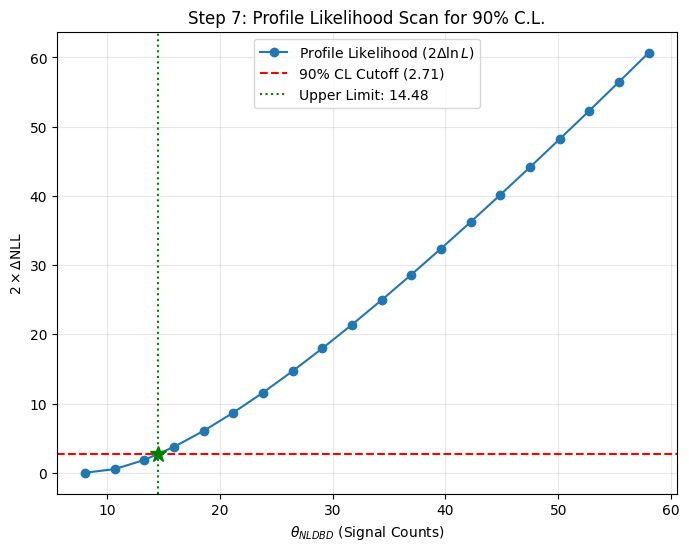

In [9]:
import scipy.interpolate as interpolate

def step_7_calculate_upper_limit(fitting_inputs, data_frames, best_fit_params, cut_threshold=0.15):
    print("--- Step 7: Calculating 90% CL Upper Limit (Profile Likelihood) ---")

    # Setup dependencies
    effs = calculate_efficiencies(data_frames, cut_threshold)
    pdfs = fitting_inputs['PDFs']
    target_counts = fitting_inputs['Target_Counts']
    constraints = {'A': (1350.0, 100.0), 'B': (770.0, 270.0)}

    # Re-verify Global Minimum NLL
    min_nll = nll_loss_corrected(best_fit_params, pdfs, target_counts, constraints, effs)
    best_theta_nldbd = best_fit_params[3]

    print(f"Global Minimum NLL: {min_nll:.4f} at Theta_NLDBD = {best_theta_nldbd:.2f}")

    # Profile Likelihood: Minimize A, B, C for fixed NLDBD values
    def profile_nll_func(params_ABC, fixed_nldbd):
        theta_A, theta_B, theta_C = params_ABC
        full_params = [theta_A, theta_B, theta_C, fixed_nldbd]
        return nll_loss_corrected(full_params, pdfs, target_counts, constraints, effs)

    # Scan upwards from best fit (scanning +50 events approx 4-5 sigma)
    scan_range = np.linspace(best_theta_nldbd, best_theta_nldbd + 50, 20)
    delta_nll_values = []

    current_guess_ABC = best_fit_params[:3]
    bounds_ABC = [(0, None), (0, None), (0, None)]

    print("Scanning Likelihood Surface...")
    for theta_val in scan_range:
        res = optimize.minimize(
            profile_nll_func,
            current_guess_ABC,
            args=(theta_val,),
            method='L-BFGS-B',
            bounds=bounds_ABC
        )

        # Statistic: 2 * Delta_NLL
        nll_val = res.fun
        two_delta_nll = 2 * (nll_val - min_nll)
        delta_nll_values.append(two_delta_nll)

        current_guess_ABC = res.x

    # Find intersection with Critical Value 2.706 (90% CL, 1 DOF)
    critical_value = 2.706
    f_interp = interpolate.interp1d(delta_nll_values, scan_range, kind='linear')

    try:
        upper_limit = float(f_interp(critical_value))
        print(f"\nSUCCESS: 90% CL Upper Limit found at: {upper_limit:.2f}")
    except ValueError:
        print("\nWARNING: Scan range too small! Curve did not cross 2.71.")
        upper_limit = None

    # Plot Profile Likelihood Scan
    plt.figure(figsize=(8, 6))
    plt.plot(scan_range, delta_nll_values, 'o-', label=r'Profile Likelihood ($2\Delta \ln L$)')
    plt.axhline(critical_value, color='red', linestyle='--', label='90% CL Cutoff (2.71)')

    if upper_limit:
        plt.axvline(upper_limit, color='green', linestyle=':', label=f'Upper Limit: {upper_limit:.2f}')
        plt.plot(upper_limit, critical_value, 'g*', markersize=12)

    plt.title("Step 7: Profile Likelihood Scan for 90% C.L.")
    plt.xlabel(r"$\theta_{NLDBD}$ (Signal Counts)")
    plt.ylabel(r"$2 \times \Delta$NLL")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return upper_limit

if 'final_params' in locals():
    theta_limit = step_7_calculate_upper_limit(fitting_data, loaded_data, final_params, cut_threshold=0.15)
else:
    print("Please run Step 6 first to get 'final_params'.")

## Step 8: Calculate the experimental sensitivity of $\theta_{NLDBD}$


--- Step 8 (Modified): Calculating Expected Limit (Signal Hypothesis) ---
--- Calculating Efficiencies (Cut > 0.15) ---
Detector A: 0.3834 (15334/40000 events kept)
Detector B: 0.3869 (15476/40000 events kept)
Detector C: 0.3881 (15524/40000 events kept)
Detector Target: 0.3841 (1883/4902 events kept)
Constructing Asimov Data with Signal = 1.00 events
Asimov Best Fit NLDBD: 1.00 (Should match injected ~1.00)
Scanning Likelihood Surface...

SUCCESS: Expected Upper Limit (with Signal) found at: 7.53


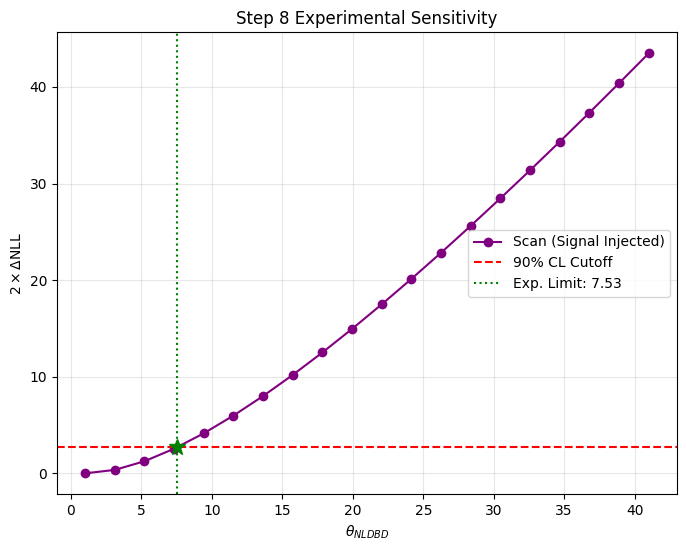

In [10]:
def step_8_expected_limit_with_signal(fitting_inputs, data_frames, best_fit_params, cut_threshold=0.15):
    print("\n--- Step 8 (Modified): Calculating Expected Limit (Signal Hypothesis) ---")

    # 1. Setup
    effs = calculate_efficiencies(data_frames, cut_threshold)
    effs = {"Detector A": 1, "Detector B": 1, "Detector C": 1, "Detector Target": 1}
    pdfs = fitting_inputs['PDFs']

    # Extract Best Fit Parameters (including Signal!)
    theta_A, theta_B, theta_C, theta_NLDBD_fit = best_fit_params
    theta_A, theta_B, theta_C, theta_NLDBD_fit = 1350.0, 770.0, 200.0, 1.0

    print(f"Constructing Asimov Data with Signal = {theta_NLDBD_fit:.2f} events")

    # 2. Generate Asimov Dataset (Background + Signal)
    asimov_counts = (theta_A * pdfs['Detector A'] +
                     theta_B * pdfs['Detector B'] +
                     theta_C * pdfs['Detector C'] +
                     theta_NLDBD_fit * pdfs['NLDBD'])

    # Create temporary fitting input
    asimov_inputs = fitting_inputs.copy()
    asimov_inputs['Target_Counts'] = asimov_counts

    # 3. Fit Asimov Data
    # ------------------
    constraints = {'A': (1350.0, 100.0), 'B': (770.0, 270.0)}
    initial_guess = [1350.0, 770.0, 500.0, 20.0] # Guess close to injected value
    bounds = [(0, None), (0, None), (0, None), (0, None)]

    res_fit = optimize.minimize(
        nll_loss_corrected,
        initial_guess,
        args=(pdfs, asimov_counts, constraints, effs),
        method='L-BFGS-B',
        bounds=bounds
    )

    asimov_best_fit = res_fit.x
    min_nll_asimov = res_fit.fun
    print(f"Asimov Best Fit NLDBD: {asimov_best_fit[3]:.2f} (Should match injected ~{theta_NLDBD_fit:.2f})")

    # 4. Profile Scan on Asimov Data
    # ------------------------------
    # Scan upwards from the best fit
    scan_range = np.linspace(asimov_best_fit[3], asimov_best_fit[3] + 40, 20)
    delta_nll_values = []

    def profile_nll_asimov(params_ABC, fixed_nldbd):
        full_params = [params_ABC[0], params_ABC[1], params_ABC[2], fixed_nldbd]
        return nll_loss_corrected(full_params, pdfs, asimov_counts, constraints, effs)

    current_guess_ABC = asimov_best_fit[:3]
    bounds_ABC = [(0, None), (0, None), (0, None)]

    print("Scanning Likelihood Surface...")
    for theta_val in scan_range:
        res = optimize.minimize(
            profile_nll_asimov,
            current_guess_ABC,
            args=(theta_val,),
            method='L-BFGS-B',
            bounds=bounds_ABC
        )
        two_delta_nll = 2 * (res.fun - min_nll_asimov)
        delta_nll_values.append(two_delta_nll)
        current_guess_ABC = res.x

    # 5. Find Intersection (Upper Limit)
    # ----------------------------------
    critical_value = 2.706
    f_interp = interpolate.interp1d(delta_nll_values, scan_range, kind='linear')

    try:
        expected_limit = float(f_interp(critical_value))
        print(f"\nSUCCESS: Expected Upper Limit (with Signal) found at: {expected_limit:.2f}")
    except ValueError:
        print("Scan range issue. Limit not found.")
        expected_limit = None

    # 6. Plot Comparison
    # ------------------
    plt.figure(figsize=(8, 6))

    plt.plot(scan_range, delta_nll_values, 'o-', color='purple', label='Scan (Signal Injected)')
    plt.axhline(critical_value, color='red', linestyle='--', label='90% CL Cutoff')

    if expected_limit:
        plt.axvline(expected_limit, color='green', linestyle=':', label=f'Exp. Limit: {expected_limit:.2f}')
        plt.plot(expected_limit, critical_value, 'g*', markersize=12)

    plt.title(f"Step 8 Experimental Sensitivity")
    plt.xlabel(r"$\theta_{NLDBD}$")
    plt.ylabel(r"$2 \times \Delta$NLL")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return expected_limit

# Run Modified Step 8
if 'final_params' in locals():
    exp_limit_signal = step_8_expected_limit_with_signal(fitting_data, loaded_data, final_params, cut_threshold=0.15)
else:
    print("Please run Step 6 first.")